In [1]:
from numpy.linalg import qr, svd

from scipy.linalg import subspace_angles

import math

import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax

import os
import sys
parent_dir = os.path.dirname(os.getcwd())  
sys.path.append(parent_dir)
from kernel_sca_inducing_points import *
from utils import *
from kernels import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score

import jPCA

In [6]:
np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/X_softNormMax_centerFalse_spikes.npy').shape

(1721, 30, 35)

In [8]:
X = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/train_spksmth.npy').swapaxes(1,2)
X.shape

(1721, 182, 35)

R2 etc (PSTH)

/var/folders/rc/1hy0j2s15dn18v_vb39s2dph0000gn/T/ipykernel_50920/1966950686.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=fontsize)
/var/folders/rc/1hy0j2s15dn18v_vb39s2dph0000gn/T/ipykernel_50920/1966950686.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=fontsize)
/var/folders/rc/1hy0j2s15dn18v_vb39s2dph0000gn/T/ipykernel_50920/1966950686.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=fontsize)
/var/folders/rc/1hy0j2s15dn18v_vb39s2dph0000gn/T/ipykernel_50920/1966950686.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a

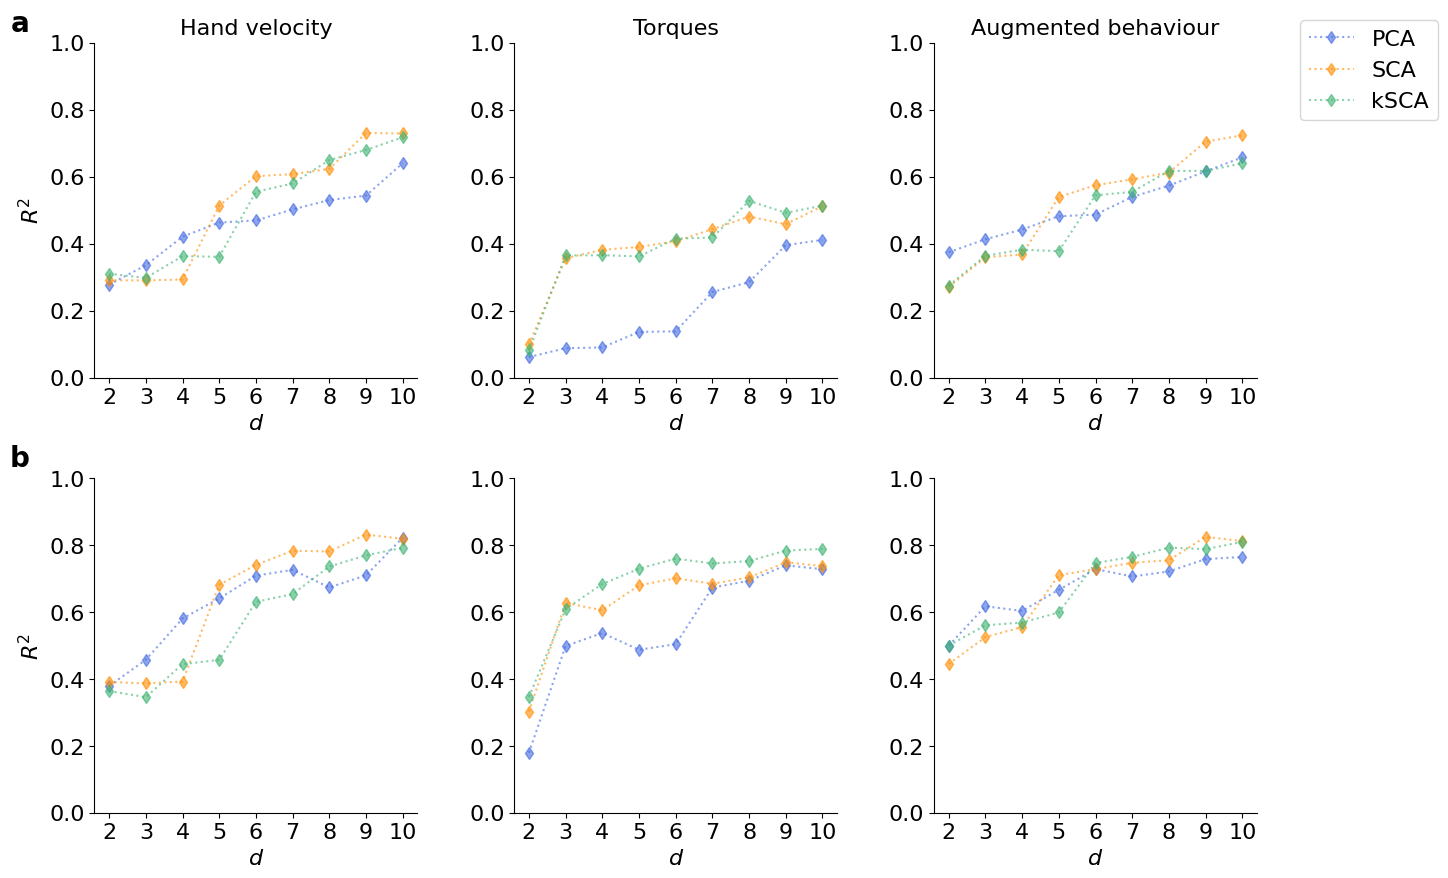

In [3]:
path = '/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/results/R2'

r2_ridge_hand_vel = [f'{path}/psth_hand_vel/ls_r2_pca.npy',
                     f'{path}/psth_hand_vel/ls_r2_sca.npy',
                     f'{path}/psth_hand_vel/ls_r2_ksca.npy']

r2_ridge_torques  = [f'{path}/psth_torques/ls_r2_pca.npy',
                     f'{path}/psth_torques/ls_r2_sca.npy',
                     f'{path}/psth_torques/ls_r2_ksca.npy']

r2_ridge_aug_behaviour  = [f'{path}/psth_aug_behaviour/ls_r2_pca.npy',
                           f'{path}/psth_aug_behaviour/ls_r2_sca.npy',
                           f'{path}/psth_aug_behaviour/ls_r2_ksca.npy']



su_psth = [f'{path}/psth_hand_vel/ls_su_pca.npy',
               f'{path}/psth_hand_vel/ls_su_sca.npy',
               f'{path}/psth_hand_vel/ls_su_ksca.npy']

principal_angle_psth = [f'{path}/psth_hand_vel/ls_principal_angle_kSCA_SCA.npy',
                   f'{path}/psth_hand_vel/ls_principal_angle_kSCA_PCA.npy',
                   f'{path}/psth_hand_vel/ls_principal_angle_SCA_PCA.npy']

def plot_data(ax, file_paths, labels, colors, loaded = False, vmin = None, vmax = None):
    for i, (file_path, label) in enumerate(zip(file_paths, labels)):
        if loaded:
            data = file_path
        else:
            data = np.load(file_path)
        ax.plot(data, label=label, color=colors[i], alpha=0.6, marker='d', linestyle=':')
        if vmin is not None:
            ax.set_ylim(vmin, vmax)

colors= ['royalblue', 'darkorange', 'mediumseagreen']
#colors=['red', 'blue', 'green']
fontsize = 16
labels = ['PCA', 'SCA', 'kSCA']
ls_behaviour = ['hand_vel', 'torques', 'aug_behaviour']

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

plot_data(axs[0, 0], r2_ridge_hand_vel, labels, colors)
plot_data(axs[0, 1], r2_ridge_torques, labels, colors)
plot_data(axs[0, 2], r2_ridge_aug_behaviour, labels, colors)

# for i, behaviour in enumerate(ls_behaviour):
#     r2_x = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/results/R2/psth_{behaviour}/r2_X.npy')
#     axs[0,i].axhline(r2_x, linestyle='-', color='silver')

ds = np.arange(2,11) #[2, 4, 6, 8, 10]
for i, behaviour in enumerate(ls_behaviour):
    ls_ksca = []
    ls_sca = []
    ls_pca = []
    for d in ds:
        ls_ksca.append(np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/results/R2/Gaussian_NN/{behaviour}/gaussian_{d}_r2 .npy') )
        ls_sca.append(np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/results/R2/Gaussian_NN/{behaviour}/linear_{d}_r2 .npy') )
        ls_pca.append(np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/results/R2/Gaussian_NN/R2_nonlinear/{behaviour}/pca_{d}_r2 .npy') )
    axs[1,i].plot(ls_pca, label='PCA', color=colors[0], alpha=0.6, marker='d', linestyle=':')
    axs[1,i].plot(ls_sca, label='SCA', color=colors[1], alpha=0.6, marker='d', linestyle=':')
    axs[1,i].plot(ls_ksca, label='kSCA', color=colors[2], alpha=0.6, marker='d', linestyle=':')

# for i, behaviour in enumerate(ls_behaviour):
#     r2_x = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/results/R2/Gaussian NN/{behaviour}/neural_r2.npy')
#     axs[1,i].axhline(r2_x, linestyle='-', color='silver')

axs[0,0].set_ylabel(r"$R^2$", fontsize = fontsize)
axs[1,0].set_ylabel(r"$R^2$", fontsize =fontsize)

axs[0,0].set_title('Hand velocity', fontsize=fontsize)
axs[0,1].set_title('Torques', fontsize=fontsize)
axs[0,2].set_title('Augmented behaviour', fontsize=fontsize)
# axs[1,0].set_title('Hand velocity \n (Gaussian NN)', fontsize=fontsize)
# axs[1,1].set_title('Torques \n (Gaussian NN)', fontsize=fontsize)
# axs[1,2].set_title('Augmented behaviour \n (Gaussian NN)', fontsize=fontsize)
axs[0, 2].legend(fontsize=fontsize, loc='upper left', bbox_to_anchor=(1.1, 1.1))

for row in range(axs.shape[0]):  # Loop over the rows
    for ax in axs[row]:  # Loop over each axis in the current row
        ax.set_xlabel(r"$d$", fontsize=fontsize)
        ax.set_xticklabels(ax.get_xticks(), fontsize=fontsize)
        ax.set_xticks(np.arange(len(ds)), ds)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=fontsize)

        if row == 0:
            ax.set_ylim([0, 1])  # First row y-limits
        elif row == 1:
            ax.set_ylim([0, 1])

for i, label in enumerate(['a', 'b']):
    axs[i, 0].text(-0.2, 1.1, label, transform=axs[i, 0].transAxes, fontsize=fontsize+4, fontweight='bold', va='top', ha='right')
plt.subplots_adjust(hspace=0.3, wspace=0.3)


R2 etc (single trials)

/var/folders/rc/1hy0j2s15dn18v_vb39s2dph0000gn/T/ipykernel_50920/569052120.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=fontsize)
/var/folders/rc/1hy0j2s15dn18v_vb39s2dph0000gn/T/ipykernel_50920/569052120.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=fontsize)


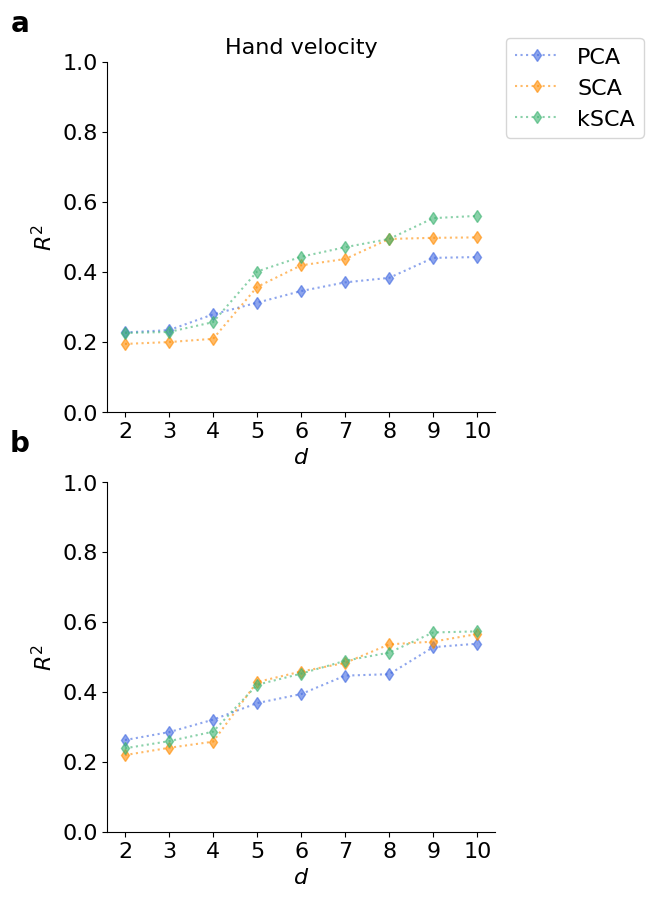

In [4]:
# plt.rcParams['text.usetex'] = True
# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = 'Computer Modern Roman'
# plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

path = '/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/results/R2'

r2_ridge_hand_vel = [f'{path}/spikes_hand_vel/ls_r2_pca.npy',
                     f'{path}/spikes_hand_vel/ls_r2_sca.npy',
                     f'{path}/spikes_hand_vel/ls_r2_ksca.npy']

fontsize = 16
fig, axs = plt.subplots(2,1, figsize=(5,10))
axs = axs.flatten()
plot_data(axs[0], r2_ridge_hand_vel, labels, colors)
axs[0].set_ylim([0, 1])
axs[0].set_title('Hand velocity', fontsize=fontsize)
axs[0].legend(fontsize=fontsize, loc='upper left', bbox_to_anchor=(1, 1.1))

ls_ksca = []
ls_sca = []
ls_pca = []
for d in ds:
    ls_ksca.append(np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/results/R2/Gaussian_NN/hand_vel_spikes/gaussian_{d}_r2 .npy') )
    ls_sca.append(np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/results/R2/Gaussian_NN/hand_vel_spikes/linear_{d}_r2 .npy') )
    ls_pca.append(np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/results/R2/Gaussian_NN/R2_nonlinear/hand_vel_spikes/pca_{d}_r2 .npy') )
axs[1].plot(ls_pca, label='PCA', color=colors[0], alpha=0.6, marker='d', linestyle=':')
axs[1].plot(ls_sca, label='SCA', color=colors[1], alpha=0.6, marker='d', linestyle=':')
axs[1].plot(ls_ksca, label='kSCA', color=colors[2], alpha=0.6, marker='d', linestyle=':')
axs[1].set_ylim([0, 1])

for ax in axs.flatten():
    ax.set_xlabel(r"$d$", fontsize=fontsize)
    ax.set_xticklabels(ax.get_xticks(), fontsize=fontsize)
    ax.set_xticks(np.arange(len(ds)), ds)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.set_ylabel(r"$R^2$", fontsize=fontsize)

for i, label in enumerate(['a', 'b']):
    axs[i].text(-0.2, 1.15, label, transform=axs[i].transAxes, fontsize=fontsize+4, fontweight='bold', va='top', ha='right')
plt.subplots_adjust(wspace=0.5)



PLOTTING Projections

In [6]:
#var explained psths
var_pca_psth = np.cumsum(np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/pca_psth/softNorm/var_explained.npy'))[1:]*100
var_sca_psth = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/results/R2/psth_hand_vel/ls_var_explained_sca.npy')*100
var_ksca_psth = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/results/R2/psth_hand_vel/ls_var_explained_ksca.npy')*100

#var explained spikes 
var_pca_spikes = np.cumsum(np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/pca_spikes/softNorm/var_explained.npy'))[1:]*100
var_sca_spikes = []
var_ksca_spikes = []
for d in np.arange(2,11):
    var_sca_spikes.append(np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/results/R2/spikes_hand_vel/var_explained_spikes/var_{d}d_linear.npy')*100)
    var_ksca_spikes.append(np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/results/R2/spikes_hand_vel/var_explained_spikes/var_{d}d_gaussian.npy')*100)


/var/folders/rc/1hy0j2s15dn18v_vb39s2dph0000gn/T/ipykernel_36866/3737823136.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=fontsize)
/var/folders/rc/1hy0j2s15dn18v_vb39s2dph0000gn/T/ipykernel_36866/3737823136.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=fontsize)
/var/folders/rc/1hy0j2s15dn18v_vb39s2dph0000gn/T/ipykernel_36866/3737823136.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=fontsize)
/var/folders/rc/1hy0j2s15dn18v_vb39s2dph0000gn/T/ipykernel_36866/3737823136.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or usi

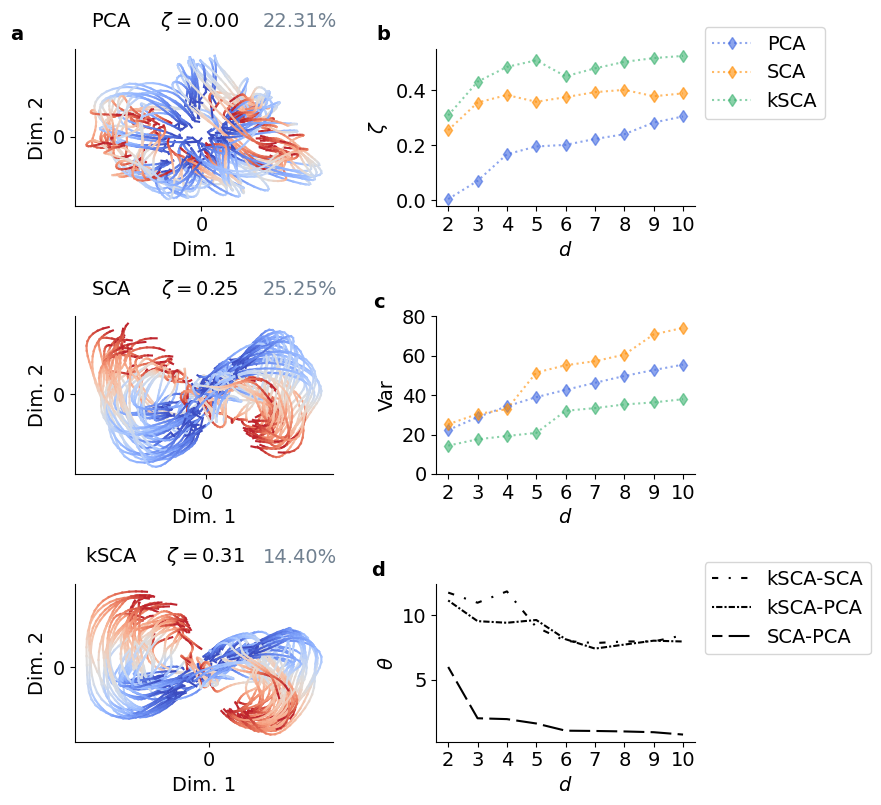

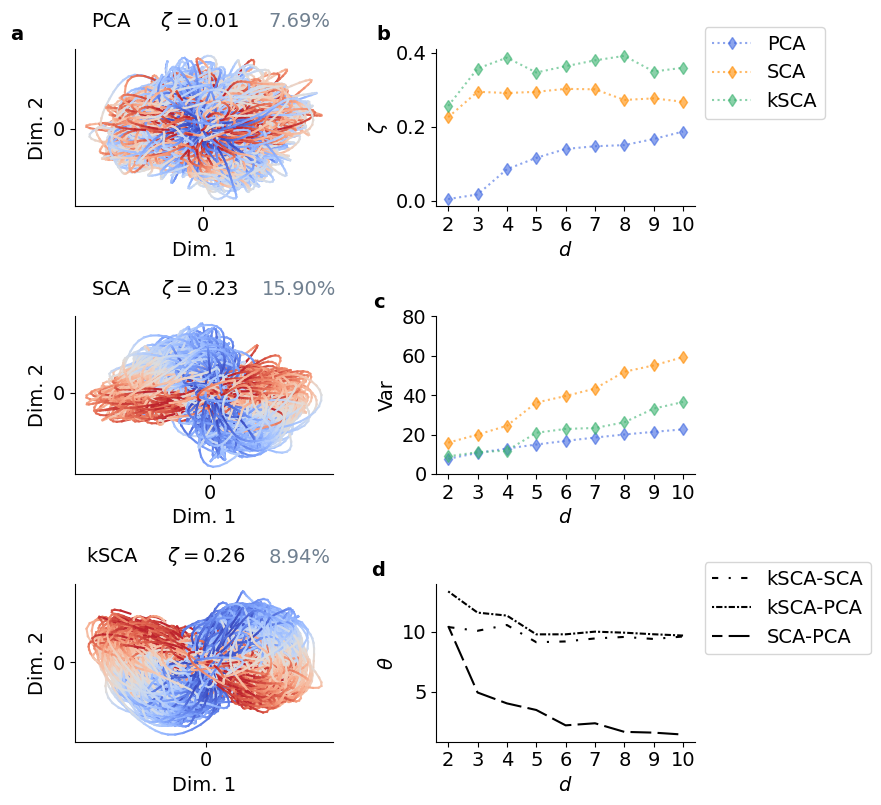

In [7]:
path = '/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/'

ls_var_explained_psth = [
    var_pca_psth,
    var_sca_psth,
    var_ksca_psth
]

ls_var_explained_spikes = [
    var_pca_spikes,
    var_sca_spikes,
    var_ksca_spikes
]

ls_projections_2D = [f'{path}/pca_psth/softNorm/Y_pca_2d.npy',
                     f'{path}/kernel_/neural_psth/projection_2d_linear.npy',
                     f'{path}/kernel_/neural_psth/projection_2d_gaussian.npy']

ls_projections_2D_individual_trials = [f'{path}/pca_spikes/softNorm/Y_pca_2d.npy',
                     f'{path}/kernel_/neural_spikes/projection_2d_linear.npy',
                     f'{path}/kernel_/neural_spikes/projection_2d_gaussian.npy']

ls_projections_3D = [f'{path}/pca_psth/Y_pca_3d.npy',
                     f'{path}/kernel_/neural_psth/projection_3d_linear.npy',
                     f'{path}/kernel_/neural_psth/projection_3d_gaussian.npy']

path = '/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/results/R2'

su_psth = [f'{path}/psth_hand_vel/ls_su_pca.npy',
               f'{path}/psth_hand_vel/ls_su_sca.npy',
               f'{path}/psth_hand_vel/ls_su_ksca.npy']

principal_angle_psth = [f'{path}/psth_hand_vel/ls_principal_angle_kSCA_SCA.npy',
                   f'{path}/psth_hand_vel/ls_principal_angle_kSCA_PCA.npy',
                   f'{path}/psth_hand_vel/ls_principal_angle_SCA_PCA.npy']

su_spikes = [f'{path}/spikes_hand_vel/ls_su_pca.npy',
      f'{path}/spikes_hand_vel/ls_su_sca.npy',
      f'{path}/spikes_hand_vel/ls_su_ksca.npy']

principal_angle_spikes = [f'{path}/spikes_hand_vel/ls_principal_angle_kSCA_SCA.npy',
                   f'{path}/spikes_hand_vel/ls_principal_angle_kSCA_PCA.npy',
                   f'{path}/spikes_hand_vel/ls_principal_angle_SCA_PCA.npy']

def set_custom_title(ax, title, subtitle, fontsize):
        #ax.set_title(title, fontsize=fontsize, loc='left')
        ax.text(0.35, 1.1, title, transform=ax.transAxes, fontsize=fontsize, color='black',
                ha='center', va='bottom')

        ax.text(0.87, 1.1125, subtitle, transform=ax.transAxes, fontsize=fontsize, color='slategrey',
                ha='center', va='bottom')

def plot_projs(ls_projections, ls_su, ls_principal_angle, ls_var):
    def plot_2D(ax, Y, title,  var, fontsize):
        cmap = plt.get_cmap('coolwarm')
        num_time_points = Y.shape[-1]
        indices_to_plot = np.arange(0, Y.shape[0], 1)
        for i in indices_to_plot:
            x = Y[i, 0, :]
            y = Y[i, 1, :]
            for t in range(num_time_points - 1):
                ax.plot(x[t:t+2], y[t:t+2], color=cmap(t / (num_time_points - 1)))
        ax.set_xlabel('Dim. 1', fontsize=fontsize)
        ax.set_ylabel('Dim. 2', fontsize=fontsize)
        ax.tick_params(axis='both', labelsize=fontsize)
        zeta = np.abs(compute_S_all_pairs(jnp.array(Y)))
        #ax.set_title(f'{title}   ' + r'$\zeta = {:.2f}$'.format(zeta) + f'{var*100:.2f}%', fontsize=fontsize)
        set_custom_title(ax, f'{title}     ' + r'$\zeta = {:.2f}$'.format(zeta), f'{var:.2f}%', fontsize=fontsize)
        ax.spines[['top','right']].set_visible(False)
        ax.grid(False) 

    fontsize=14
    fig, axs = plt.subplots(3, 2, figsize=(8, 9))
    axs = axs.flatten()
    ls_titles = ['PCA', 'SCA', 'kSCA']
    plot_data(axs[1], ls_su, ls_titles, colors)
    axs[1].set_ylabel(r"$\zeta$", fontsize=fontsize)

    plot_data(axs[3], ls_var, ls_titles, colors, loaded=True, vmin = 0, vmax = 80)
    axs[3].set_ylabel("Var", fontsize=fontsize)

    axs[5].plot(np.load(ls_principal_angle[0]), color='black', linestyle=(0, (3, 5, 1, 5)), label='kSCA-SCA')
    axs[5].plot(np.load(ls_principal_angle[1]), color='black', linestyle = (10,(3, 1, 1, 1)), label='kSCA-PCA')
    axs[5].plot(np.load(ls_principal_angle[2]), color='black', linestyle=(5, (10, 3)), label='SCA-PCA')

    axs[5].set_ylabel(r'$\theta$', fontsize=fontsize) # [deg]

    axs[1].legend(fontsize=fontsize, loc='upper left',  bbox_to_anchor=(1, 1.2), ncol=1) #loc='upper left', bbox_to_anchor=(0.6, 1.5) #len(ls_titles)
    axs[5].legend(fontsize=fontsize, loc='upper left',  bbox_to_anchor=(1, 1.2), ncol=1)  #loc='upper left', bbox_to_anchor=(0.4, 1.5),

    #axs[5].axis('off')

    ids = [0, 2, 4]
    for i, path in enumerate(ls_projections):
        data = np.load(path)
        plot_2D(axs[ids[i]], data, ls_titles[i], ls_var[i][0] ,fontsize=fontsize)

    #fig.text(0.05, 1, 'a', va='center', rotation='horizontal', fontsize=fontsize_big, fontweight='bold')
    # fig.text(0.19, 0, 'PCA', va='center', rotation='horizontal', fontsize=fontsize_big)
    # fig.text(0.397, 0, 'SCA', va='center', rotation='horizontal', fontsize=fontsize_big)
    # fig.text(0.605, 0, 'kSCA', va='center', rotation='horizontal', fontsize=fontsize_big)

    # cbar_ax = fig.add_axes([0.43, 0.16, 0.004, 0.1])  
    # cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=-250, vmax=450)), cax=cbar_ax, orientation='vertical')
    # cbar.set_ticks([-250, 450])
    # cbar.set_ticklabels(['-250', '+450'], fontsize=fontsize)
    # cbar.set_label('Time [ms]', fontsize=fontsize)

    for i, ax in enumerate(axs):
        if i == 1 or i ==3 or i == 5: 
            ax.set_xlabel(r"$d$", fontsize=fontsize)
            ax.set_xticklabels(ax.get_xticks(), fontsize=fontsize)
            ax.set_xticks(np.arange(len(ds)), ds)
        else:
            ax.set_xticks([0])
            ax.set_yticks([0])
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=fontsize)

    #for i, label in enumerate(['a', 'b']):
    axs[0].text(-0.2, 1.15, 'a', transform=axs[0].transAxes, fontsize=fontsize, fontweight='bold', va='top', ha='right')
    axs[1].text(-0.18, 1.15, 'b', transform=axs[1].transAxes, fontsize=fontsize, fontweight='bold', va='top', ha='right')
    axs[3].text(-0.2, 1.15, 'c', transform=axs[3].transAxes, fontsize=fontsize, fontweight='bold', va='top', ha='right')
    axs[5].text(-0.2, 1.15, 'd', transform=axs[5].transAxes, fontsize=fontsize, fontweight='bold', va='top', ha='right')

    plt.subplots_adjust(wspace=0.4, hspace=0.7)

plot_projs(ls_projections_2D, su_psth, principal_angle_psth, ls_var_explained_psth)

plot_projs(ls_projections_2D_individual_trials, su_spikes, principal_angle_spikes, ls_var_explained_spikes)


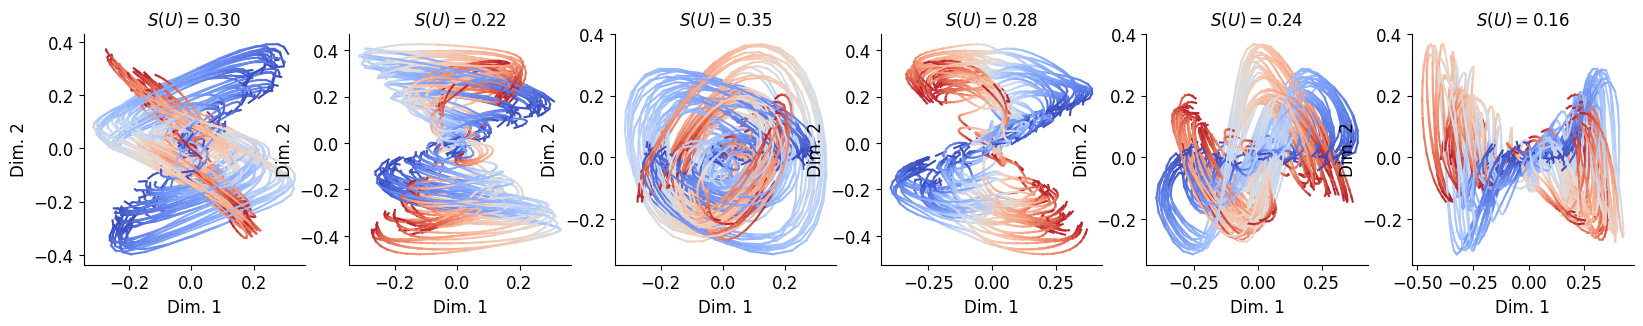

In [39]:
path = '/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/'
test = np.load(f'{path}/kernel_/neural_psth/projection_4d_gaussian.npy')

fig, axs = plt.subplots(1,6, figsize=(20,3))
ids = [0,1]
plot_2D(axs[0], test[:,ids, :])
ids = [0,2]
plot_2D(axs[1], test[:,ids, :])
ids = [0,3]
plot_2D(axs[2], test[:,ids, :])
ids = [1,2]
plot_2D(axs[3], test[:,ids, :])
ids = [1,3]
plot_2D(axs[4], test[:,ids, :])
ids = [2,3]
plot_2D(axs[5], test[:,ids, :])

Text(0.05, 1, 'b')

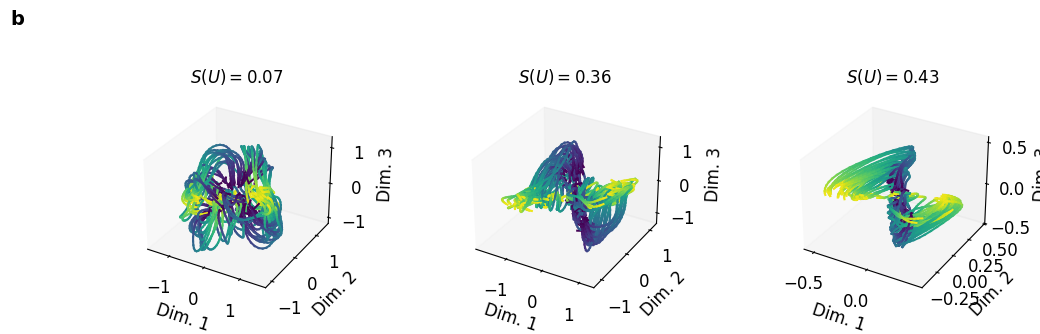

In [54]:
def plot_3D(ax, Y, title, fontsize=fontsize):
    cmap = plt.get_cmap('coolwarm')
    num_time_points = Y.shape[-1]
    indices_to_plot = np.arange(0, Y.shape[0], 1)
    for i in indices_to_plot:
        x = Y[i, 0, :]
        y = Y[i, 1, :]
        z = Y[i, 2, :]
        for t in range(num_time_points - 1):
            ax.plot(x[t:t+2], y[t:t+2], z[t:t+2], color=cmap(t / (num_time_points - 1)))
    ax.set_xlabel('Dim. 1', fontsize=fontsize)
    ax.set_ylabel('Dim. 2', fontsize=fontsize)
    ax.set_zlabel('Dim. 3', fontsize=fontsize)
    ax.tick_params(axis='both', labelsize=fontsize)  
    ax.tick_params(axis='z', labelsize=fontsize)
    zeta = np.abs(compute_S_all_pairs(jnp.array(Y)))
    ax.set_title(rf'{title} \n $\zeta = {zeta:.2f}$', fontsize=fontsize)
    ax.spines[['top','right']].set_visible(False)
    ax.grid(False) 

fig = plt.figure(figsize=(12, 6))
axs = [fig.add_subplot(2, 3, i + 1, projection='3d') for i in range(3)]
for i, path in enumerate(ls_projections_3D):
    data = np.load(path)
    plot_3D(axs[i], data)

fig.text(0.05, 1, 'b', va='center', rotation='horizontal', fontsize=fontsize_big, fontweight='bold')